***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [5. Imaging](5_0_introduction.ipynb)  
    * Previous: [5.1 Spatial Frequencies](5_1_spatial_frequencies.ipynb)  
    * Next: [5.3 Gridding and Degridding for using the FFT](5_3_gridding_and_degridding.ipynb)

***

Import standard modules:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import section specific modules:

In [6]:
import matplotlib.image as mpimg
from IPython.display import Image
import aplpy

ImportError: No module named aplpy

***

## 5.2 Sampling and Point Spread Functions <a id='imaging:sec:samplingPSF'></a>

For a moment let us discuss radio interferometry and the sky. We can think of the sky as being a 'continuous' image. What I mean by 'continuous' here is that the sky is spatial continuous, as opposed to a digital image which consists of spatially discrete pixels. The Fourier transform of a continuous function is another continous function. Thus, there is some continuous function in the visibility domain which is the Fourier transform of the continuous sky. As a hint of what is to come, we will see that an interferometric array measures, i.e. samples, the continuous visibility domain function. These measurements, colloquially called *visibilities*, can be used to reconstruct, at least partially, an image of the sky. The process of this reconstruction will be presented throughout this chapter. With that motivation let us return to the discussion at hand.

At the end of Section 5.1 we saw how the random sampling of the spatial frequency (visibility) domain reconstructs the original image to varying degrees of quality dependent on the number of samples used. Even without complete information, much of the original image can be recovered. In this section we will expand on that idea to show how different samplings of the visibility space will result in different characteristics in the image domain.

### 5.2.1 Regular Sampling

A standard method to convert a continuous signal into a discrete signal to apply a regularly-spaced function called a Shah (or Dirac comb, or bed of nails) function to the continous signal. This is equivalent to the concept of digitization. The 1-D Shah function is

$$\operatorname{III}_a(x) = \sum_{n=-\infty}^{+\infty} \delta(x+an)$$

where $\delta(x)$ is the Dirac Delta function and $a$ is a scaling factor to set the width between samples. Thus, a continuous function $f(x)$ can be sampled with the Shah function to produce a discrete function $f_n(x)$

$$f_n(x) = \operatorname{III}_a(x)\,\,f(x) = \sum_{n=-\infty}^{+\infty} f(x)\,\,\delta(x+an)$$

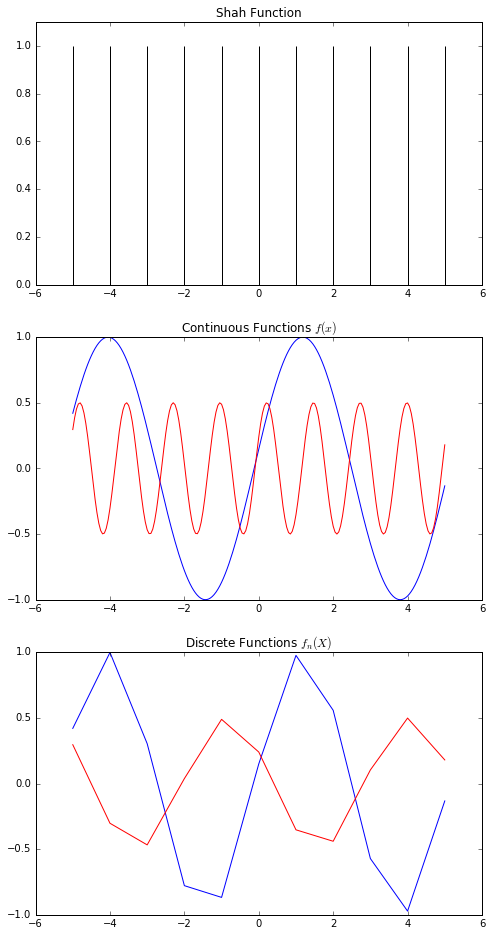

In [7]:
xpos = np.linspace(-5, 5, num=200+1)
shah = np.where(xpos.astype(int)==xpos, 1, 0)

fig, axes = plt.subplots(figsize=(8,16))

plt.subplot(3,1,1)
plt.vlines(xpos[np.argwhere(shah > 0)], 0, 1)
plt.ylim(0, 1.1)
plt.title('Shah Function')

plt.subplot(3,1,2)
cont0 = np.sin(1.2 * xpos + 0.15)
cont1 = 0.5 * np.sin(5 * xpos + 0.5)
plt.plot(xpos, cont0, 'b-')
plt.plot(xpos, cont1, 'r-')
plt.title('Continuous Functions $f(x)$')

plt.subplot(3,1,3)
discrete0 = shah * cont0
discrete1 = shah * cont1
plt.plot(xpos[np.argwhere(np.abs(shah) > 0)], discrete0[np.argwhere(np.abs(shah) > 0)], 'b-')
plt.plot(xpos[np.argwhere(np.abs(shah) > 0)], discrete1[np.argwhere(np.abs(shah) > 0)], 'r-')
plt.title('Discrete Functions $f_n(X)$')

*Figure: the effect of applying a Shah or Dirac Comb to a continuous signal. Top: the Shah function with a scaling factor of $a=1$, thus the Nyquist limit is $2a = 2$. Middle: a continuous Sine function with a frequency of $1.2$ (blue) and $5$ (red). Bottom: The discrete Sine functions after sampling by the Shah function. Since the blue Sine wave rate $1.2 \le 2$, the function is sufficiently sampled, but the red Sine wave is $5 > 2$ the function is aliased to a lower frequency.*

The effect of applying a Shah function to sample a continuous signal is that the now discretely sampled signal is bandlimited to a Nyquist rate of $2a$. Periodic signals with rates larger than $2a$ will be aliased to lower frequencies.

This formulation is easily extended to higher dimensions, for example the 2-D Shah function is

$$\operatorname{III}_{a,b}(x, y) = \sum_{n=-\infty}^{+\infty} \sum_{m=-\infty}^{+\infty} \delta(x+an, y+bn)$$

We can use this function to sample a continuous sky image into a digital image, such as is done with a telescope and CCD camera. But, in radio astronomy that is not possible due to a number of issues with scale, technology, and sensitivity. Instead, we use an irregular sampling method. 

### 5.2.2 A Generalized Sampling Function

Regular sampling functions are a special case of the general sampling function which happen to be equally spaced in sampling postion. But, as we will see, regular sampling is a rare case in interferometry. Instead, the sampling functions will be a function of the interferometric array configuration, obsevration bandwidth, sky pointing direction, and data flagging among other issues. The general 2-D sampling function form an arbitrary set of $Q$ pairs $(x_i, y_i), i \le Q$

$$S(x, y) = \sum_{i=1}^{Q} \delta(x+x_i, y+y_i)$$

This equation can be further generalized to a *weighted sampling function*

$$S(x, y) = \sum_{i=1}^{Q} w_i \,\, \delta(x+x_i, y+y_i)$$

Which can be used to weight individual samples, for example the weight can indicate the reliability of the sample in a noisy system. Or, as we will see, this weight is used to shape the resulting image response, but that is getting ahead of ourselves.

The general weighted 2-D sampling function applied to a continuous signal is

$$f(X, Y) = S(x, y) \,\, f(x,y) = \sum_{i=1}^{Q} w_i \,\, \delta(x+x_i, y+y_i) \,\, f(x, y)$$

By sampling a function we are inherently losing information as we are only measuring part of a signal. The next step is to understand how our choice of sampling effects what we can recover, especially when we are sampling in the spatial frequency (visibility) domain to recover an image in the spatial (image) domain.

### 5.2.3 The Point Spread Function (PSF)

The term *Point Spread Function* comes up in a lot of astronomy and photography, the term refers to the response of a measurement system to perfect point source. In optical astronomy stars are usually 'unresolved', that is the resolution of the telescope is insufficient to measure the angular size of the star. So, a star can effectively be considered a point source. The optics of the telescope then impose a structure on the entire image which can be seen in strong point sources.

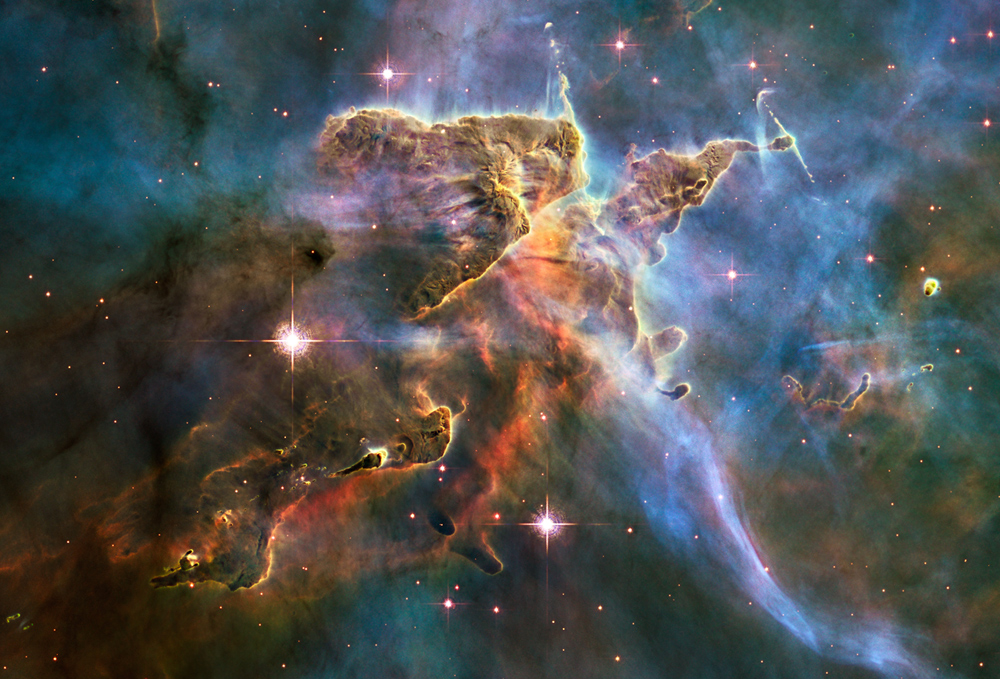

In [8]:
Image(filename='figures/hs-2010-13-g-large_web.jpg')

*Figure: Carina Nebula image from the Hubble Telescope, the cross pattern and airy pattern from the stars in the foreground is the point spread function of the telecsope due to the optics.*
[Credit: NASA, ESA, and M. Livio and the Hubble 20th Anniversary Team (STScI)](http://hubblesite.org/gallery/album/star/pr2010013g/)

In radio astronomy there are two types of PSFs, the first is the same as in optical astronomy where the shape of the optics imposes a response to a point source. This is PSF relates to the antenna beam and can be ignored for now. When discussing radio interferometry the term PSF relates to the geometry of the array configuration, that is how the array *samples* the visibility domain. For the moment we will simply state that the PSF of an interferometric array (in fact any telescope) is the Fourier transform of the visibility domain sampling function.

$$\text{PSF}(l,m) \rightleftharpoons S(u,v)$$

To add some interferometry specific notation we describe positions in the visibility domain in terms of $u$ and $v$, the term $uv$-space is often used as a synonm for the visibility domain. Positions in the image domain are denoted with $l$ and $m$, both of which range $-1 \le l,m \le 1$. These terms are more fully described in the  [Visibility Space]() chapter. For both the image and visibility domain $(0,0)$ is at the centre like a Cartesian coordinate system. In historical literature the term *synthesized beam* is often used, this is equivalent to the PSF.

The resulting *obsvered signal* from a measurement system is the convolution of the *true signal* with the PSF of the system

$$I_{obs} = \text{PSF} \ast I_{true} $$

For the moment, we will skip the mathematical complexities of why the PSF and sampling functions are Fourier pairs, and the relations between the observed and true images. Instead, we will graphically look at some examples of simple sampling functions, what type of PSF is produced and how it affects an image.

We will continue to use the same example images from the previous section, and for simplicity convert the RGB-color images to grayscale:

In [9]:
#soccer = mpimg.imread('figures/WLA_moma_Umberto_Boccioni_Dynamism_of_a_Soccer_Player_1913_512.png')
cyclist = mpimg.imread('figures/Umberto_Boccioni_Dynamism_of_a_Cyclist_512.png')
duck = mpimg.imread('figures/Anas_platyrhynchos_male_female_quadrat_512.png')

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b #standard grayscale conversion
    return gray

gCyclist = rgb2gray(cyclist)
gDuck = rgb2gray(duck)

The most simple telescope we can imagine is a circular lense which refracts light to a measurment point, this is a refracting telescope in the style of Galileo's original design. The lense, which has a certain circumference defines the maximum resolution of the telescope and the 2-D cross section of the lense, a disk, is the 'sampling' function. That is, all light within the circumference of the lense is seen, and all light beyond the lense is excluded. The sampling function of this telescope is a binary disk.

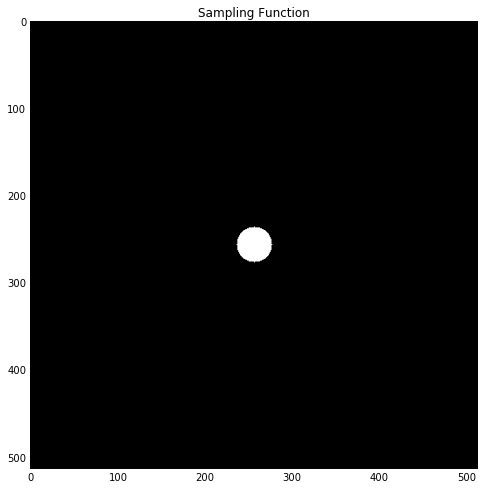

In [10]:
def circularSamplingMap(imgSize, outer, inner=0):
    """Return a circular sampling map of size [imgSize, imgSize]
    imgSize: image size in pixels
    outer: outer radius (in pixels) to exclude sampling above
    inner: inner radius (in pixels) to exclude sampling below"""
    zeros = np.zeros((imgSize,imgSize), dtype='float')
    ones = np.ones((imgSize,imgSize), dtype='float')
    xpos, ypos = np.mgrid[0:imgSize,0:imgSize]
    radius = np.sqrt((xpos - imgSize/2)**2. + (ypos - imgSize/2)**2.)
    sampling = np.where((outer >= radius) & (radius >= inner), ones, zeros)
    return sampling

sampling = circularSamplingMap(512, 20, 0)
fig, axes = plt.subplots(figsize=(8,8))
samplingPlot = plt.imshow(sampling)
plt.title('Sampling Function')
samplingPlot.set_cmap('gray')

*Figure: sampling function of a simple refractor telescope.*

We can then compute the PSF of this telescope using a Fourier transform.

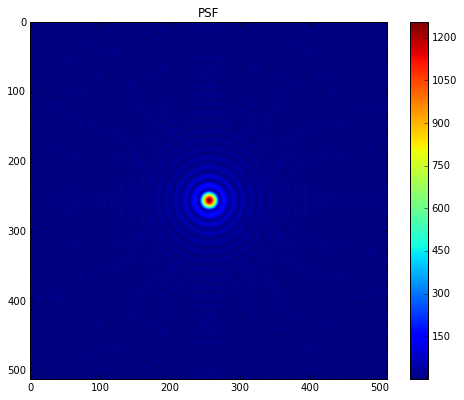

In [11]:
fig, axes = plt.subplots(figsize=(8,8))
psfPlot = plt.imshow(np.abs( np.fft.fftshift( np.fft.fft2(sampling))))
plt.title('PSF')
plt.colorbar(shrink=0.8)

*Figure: the PSF of a simple circular sampling function, this is also called an Airy disk.*

Looking at the PSF there is large (in amplitude) central peak surrounding by rings which drop off in amplitude. This is known as an Airy disk (also called a Bessel function of the first kind, or radially symetric Sinc function), and is the Fourier transform of a radially symetric top-hat function which is what our simple sampling function is. The central peak is often called the *PSF primary lobe* and the secodary peaks, such as the rings, are the PSF *sidelobes*.

Remember, the PSF is the response of the measuring system to a point source, in this example we see that a point source will appear to be an Airy disk with a primary lobe of many pixels in size. Looking back at the Hubble image we can see that some of the bright sources have an AIry disk structure around them along with the cross patterns.

We can produce the observed image of the duck image from the previous section by taking advantage of the Fourier relation in the convolution theorem that a convolution of two function in one domain is a multiplication of those functions in the Fourier domain.

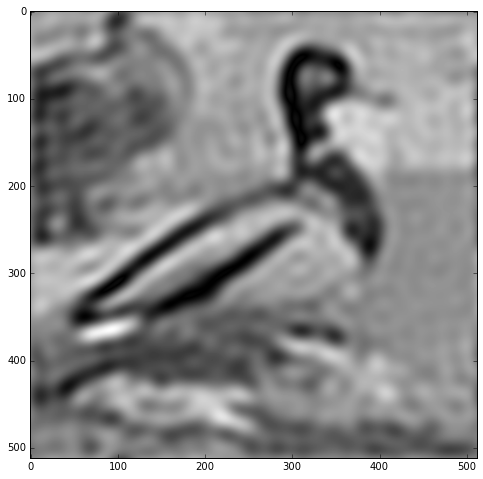

In [12]:
fftDuck = np.fft.fftshift(np.fft.fft2(gDuck)) #Fourier transform the duck to the spatial frequency domain
obsDuck = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftDuck))) #multiple by the sampling function, and Fourier transfrom back to the image domain
fig, axes = plt.subplots(figsize=(8,8))
obsPlot = plt.imshow(obsDuck)
obsPlot.set_cmap('gray')

*Figure: the obsevred image of the duck using the sampling function presented above.*

The obsevred image is quite blurry as the large PSF primary lobe affectively acts as a low-pass filter to remove the fine details.

By increasing the radius of the sampling function, i.e. using a larger telescope, we see that the PSF primary lobe gets smaller, and thus we have a higher resolution telescope as expected.

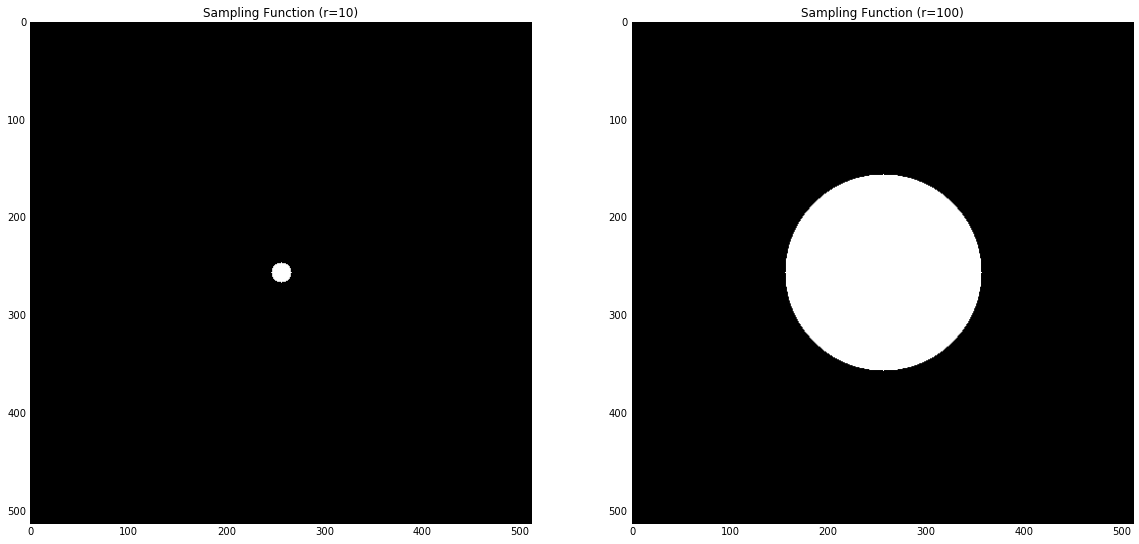

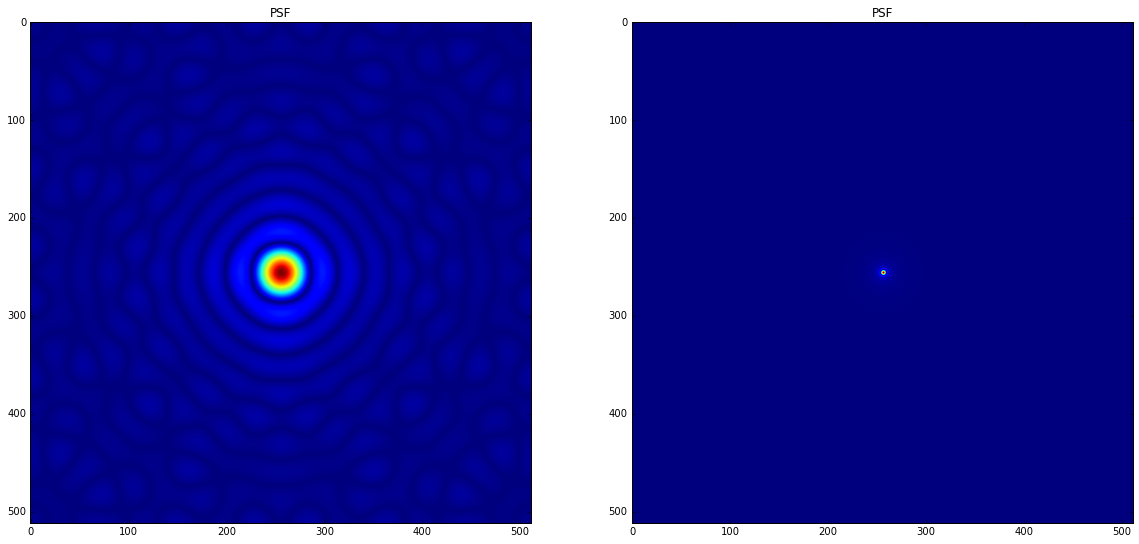

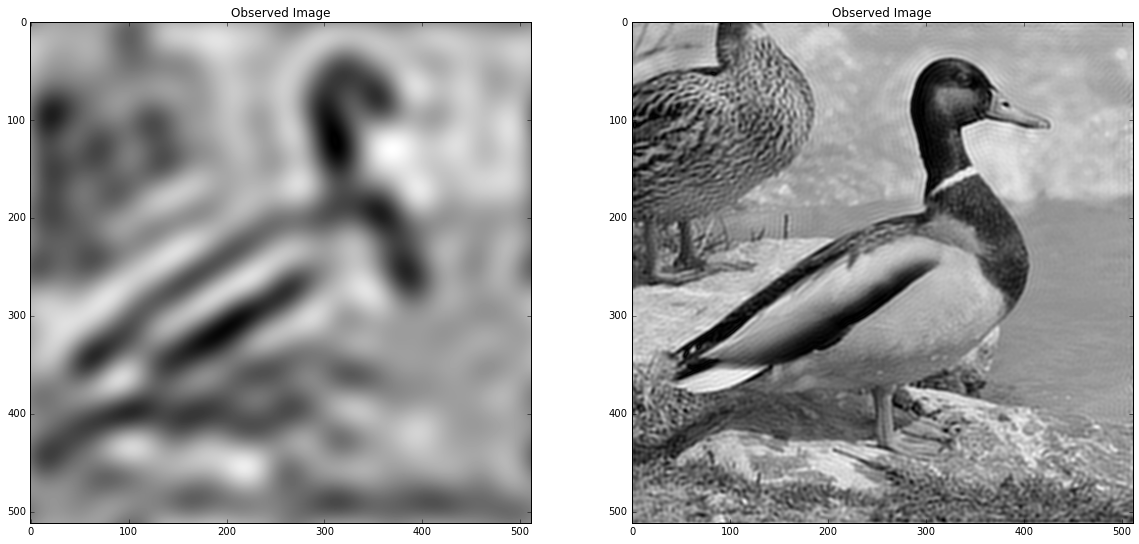

In [13]:
fig, axes = plt.subplots(figsize=(16,8))
fig.tight_layout()

plt.subplot(1,2,1)
sampling0 = circularSamplingMap(512, 10, 0)
samplingPlot = plt.imshow(sampling0)
samplingPlot.set_cmap('gray')
plt.title('Sampling Function (r=%i)'%10)

plt.subplot(1,2,2)
sampling1 = circularSamplingMap(512, 100, 0)
samplingPlot = plt.imshow(sampling1)
samplingPlot.set_cmap('gray')
plt.title('Sampling Function (r=%i)'%100)

fig, axes = plt.subplots(figsize=(16,8))
fig.tight_layout()

plt.subplot(1,2,1)
psfPlot = plt.imshow(np.abs( np.fft.fftshift( np.fft.fft2(sampling0))))
plt.title('PSF')

plt.subplot(1,2,2)
psfPlot = plt.imshow(np.abs( np.fft.fftshift( np.fft.fft2(sampling1))))
plt.title('PSF')

fig, axes = plt.subplots(figsize=(16,8))
fig.tight_layout()

plt.subplot(1,2,1)
obsDuck = np.abs(np.fft.ifft2(np.fft.fftshift(sampling0 * fftDuck)))
obsPlot = plt.imshow(obsDuck)
obsPlot.set_cmap('gray')
plt.title('Observed Image')

plt.subplot(1,2,2)
obsDuck = np.abs(np.fft.ifft2(np.fft.fftshift(sampling1 * fftDuck)))
obsPlot = plt.imshow(obsDuck)
obsPlot.set_cmap('gray')
plt.title('Observed Image')

*Figure: sampling functions (top row), resulting PSFs (middle row), and observed images (bottom row). A larger radius sampling function results in a smaller PSF response, which can be interpreted as higher resolution.*

From the left column we can see that a small disk results in a blurred out, or low resolution, image compared to the larger sampling disk in the right column. Because the right column sampling fuction does not fully sample the visibility domain a 'ringing' can be seen in the observed image, especially around the edge of the duck, due to the PSF sidelobes.

Modern telescopes are not as simple as the refactor telescope-Airy disk relation as most are some form of reflector mirror instead of lense. Most have structures which block part of the lense, such as struts to hold up equipment at the focus, or holes due to engineering constraints. We can expand on our simple sampling function to more complex shapes. Lets take a small step towards complexity by making a ring sampling function, which is fairly common in astronomy.

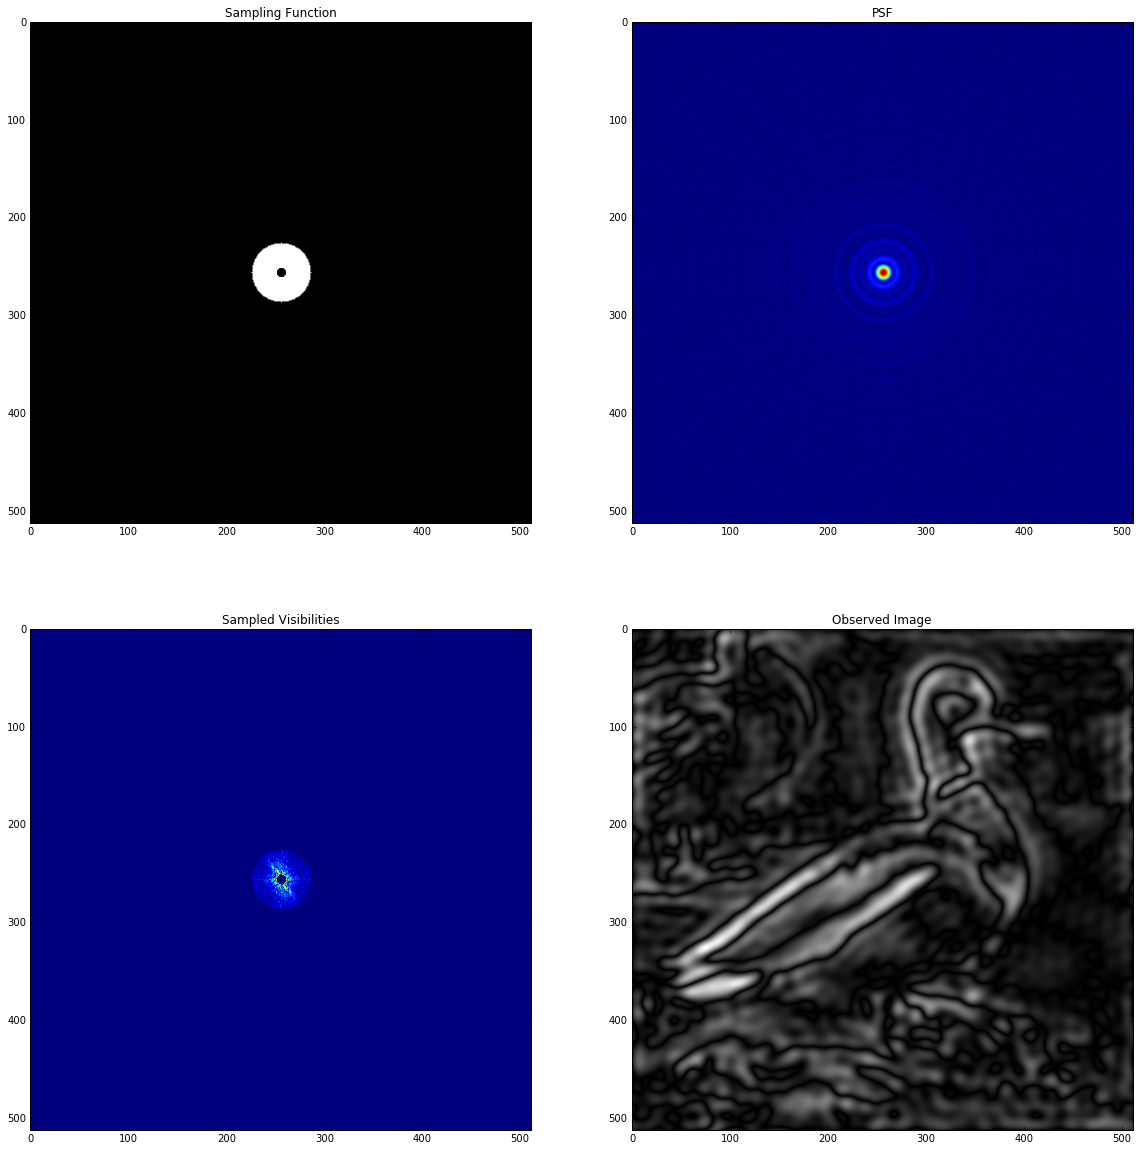

In [14]:
fig, axes = plt.subplots(figsize=(16,16))
fig.tight_layout()

plt.subplot(2,2,1)
sampling = circularSamplingMap(512, 30, 5)
samplingPlot = plt.imshow(sampling)
samplingPlot.set_cmap('gray')
plt.title('Sampling Function')

plt.subplot(2,2,2)
psfPlot = plt.imshow(np.abs( np.fft.fftshift( np.fft.fft2(sampling))))
plt.title('PSF')

plt.subplot(2,2,3)
samplingPlot = plt.imshow(np.abs(sampling * fftDuck))
plt.title('Sampled Visibilities')

plt.subplot(2,2,4)
obsDuck = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftDuck)))
obsPlot = plt.imshow(obsDuck)
obsPlot.set_cmap('gray')
plt.title('Observed Image')

*Figure: The effect of sampling a limited set of spatial frequency domain components to produce an observed image. Top left: ring sampling function, Top right: resulting PSF of the sampling function, Bottom left: the amplitude of the sampled visibilities, Bottom right: the Fourier transform of the sampled visibilities, the observed image.*

A ring sampling function can be thought of as being made up of two sampling functions, a circular 'positive' sampling function which results in an Airy disk, and small 'negative' circular sampling function, the inner section, which results in a larger Airy disk which is subtracted from the 'positive' sampling function. The resulting PSF can be seen to have sidelobes that dim but periodically brighten in radius. The observed image has a duck-like shape but is different from the first observed image we produced when the sampling function was a complete circle out to a radius of 20 pixels. We have dropped the inner 5 pixel radius visibility samples. The sum of the observed image is effectively zero, this is because the inner components represent the large scale structure of the image. For example, the sample at $(0,0)$ in the spatial frequency domain is often called the DC component (this comes from 'direct current' in signal processing) and represents the average of the image. By not sampling that component, the remaining image visibility components, when summed should be approximately zero.

In [15]:
np.sum(np.fft.ifft2(np.fft.fftshift(sampling * fftDuck))) #The sum of the observed image components is approximately zero

-3.2816613657194091e-28j

This ring sampling effectively acts as a bandpass filter which removes spatial frequency components that in the radius below 5 pixels and above 20 pixels. Creating another ring sampling function with a larger radius produces a different bandpass filter of the true image. 

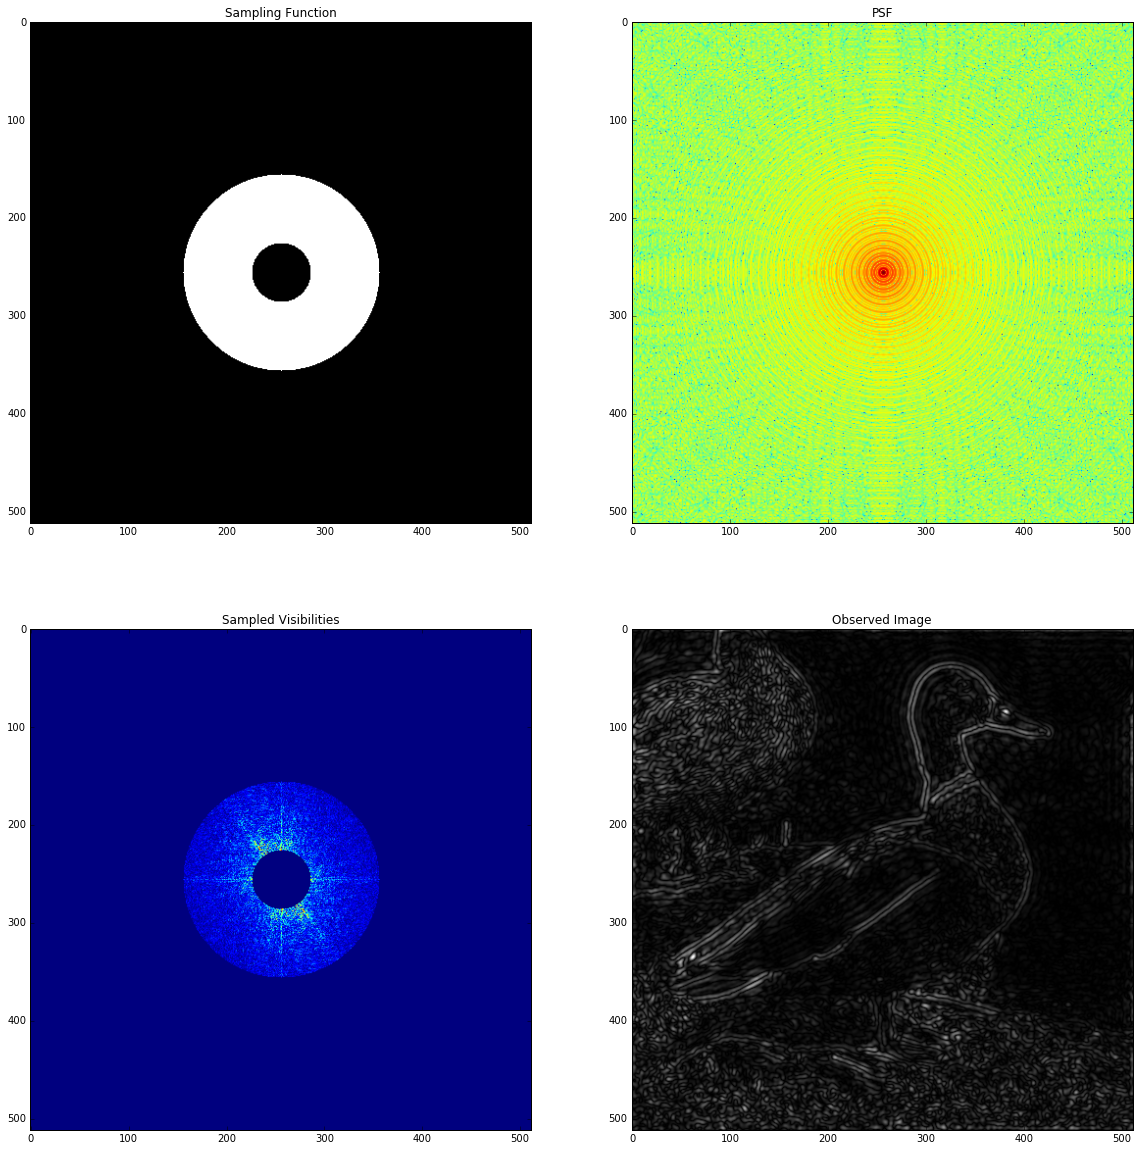

In [16]:
fig, axes = plt.subplots(figsize=(16,16))
fig.tight_layout()

plt.subplot(2,2,1)
sampling = circularSamplingMap(512, 100, 30)
samplingPlot = plt.imshow(sampling)
samplingPlot.set_cmap('gray')
plt.title('Sampling Function')

plt.subplot(2,2,2)
psfPlot = plt.imshow(10. * np.log10(np.abs( np.fft.fftshift( np.fft.fft2(sampling)))))
plt.title('PSF')

plt.subplot(2,2,3)
samplingPlot = plt.imshow(np.abs(sampling * fftDuck))
plt.title('Sampled Visibilities')

plt.subplot(2,2,4)
obsDuck = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftDuck)))
obsPlot = plt.imshow(obsDuck)
obsPlot.set_cmap('gray')
plt.title('Observed Image')

*Figure: The effect of sampling a limited set of spatial frequency domain components to produce an observed image. Top left: ring sampling function, Top right: resulting PSF of the sampling function, shown in decibels, Bottom left: the amplitude of the sampled visibilities, Bottom right: the Fourier transform of the sampled visibilities, the observed image.*

With a wider ring radius the finer details of the duck appear, some of the feathers of the duck in the background appear, the sum of the image components is still approximately zero.

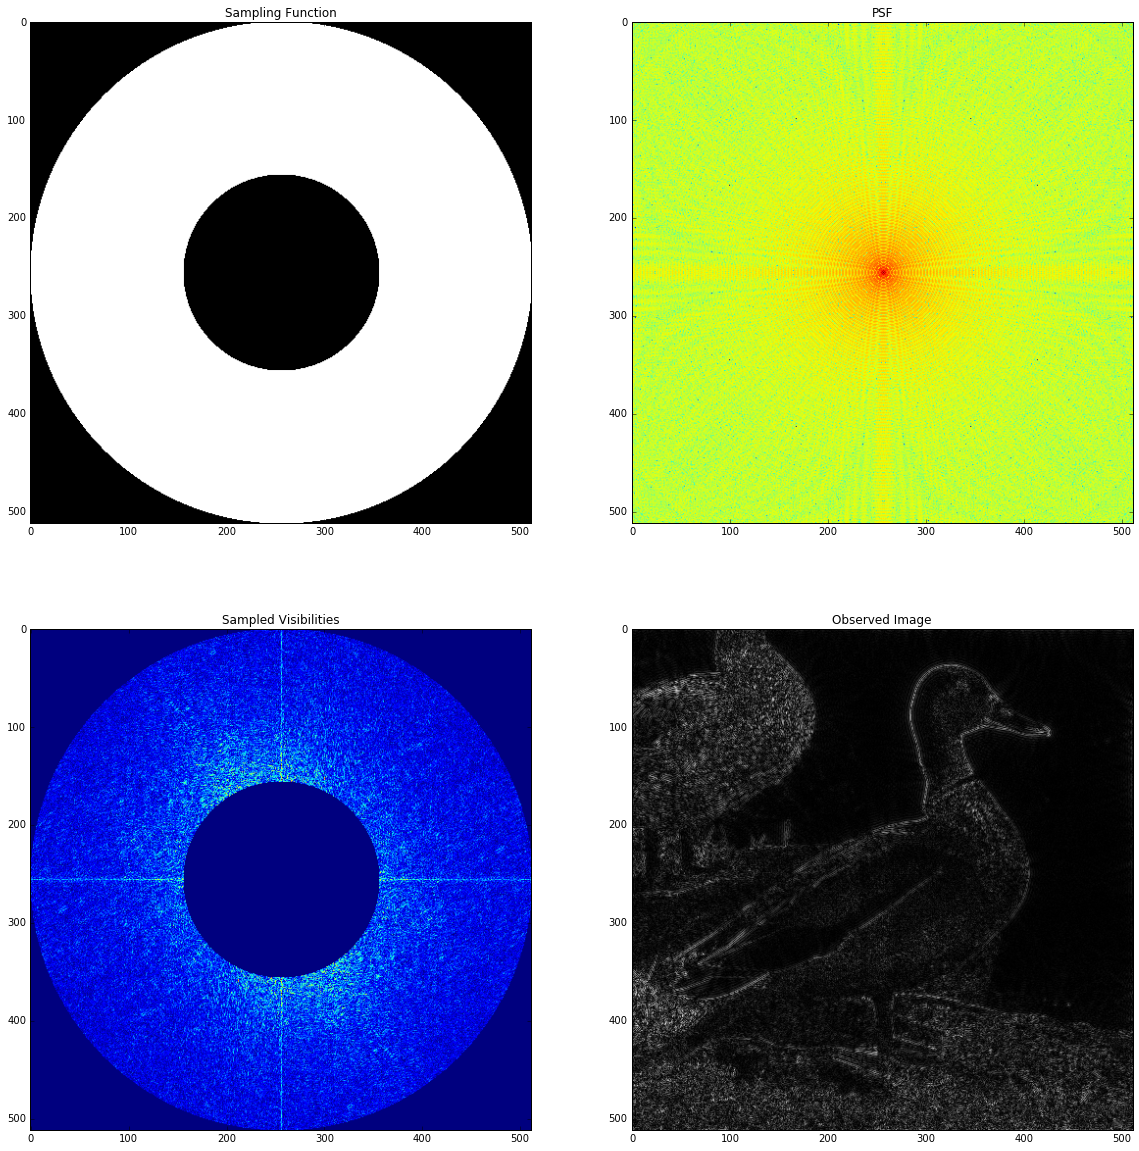

In [17]:
fig, axes = plt.subplots(figsize=(16,16))
fig.tight_layout()

plt.subplot(2,2,1)
sampling = circularSamplingMap(512, 256, 100)
samplingPlot = plt.imshow(sampling)
samplingPlot.set_cmap('gray')
plt.title('Sampling Function')

plt.subplot(2,2,2)
psfPlot = plt.imshow(10. * np.log10(np.abs( np.fft.fftshift( np.fft.fft2(sampling)))))
plt.title('PSF')

plt.subplot(2,2,3)
samplingPlot = plt.imshow(np.abs(sampling * fftDuck))
plt.title('Sampled Visibilities')

plt.subplot(2,2,4)
obsDuck = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftDuck)))
obsPlot = plt.imshow(obsDuck)
obsPlot.set_cmap('gray')
plt.title('Observed Image')

*Figure: The effect of sampling a limited set of spatial frequency domain components to produce an observed image. Top left: ring sampling function, Top right: resulting PSF of the sampling function, shown in decibels, Bottom left: the amplitude of the sampled visibilities, Bottom right: the Fourier transform of the sampled visibilities, the observed image.*

Going to an even larger radius the finest details show up in the observed image, but is fairly faint because most the power is represented in the lower spatial frequencies, thus we have also increased the total sampling area. The intuition here is that in most images the the lower spatial freqeuncy components represent most of the information in the image, and at each successively larger ring in visibility space that are more possible orientations, i.e. higher resolution, for the power to be spread over.

We can generate the resulting PSFs for a collection of different shapes.

/home/user/.virtualenv/fundamentals/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/home/user/.virtualenv/fundamentals/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in log10
/home/user/.virtualenv/fundamentals/lib/python2.7/site-packages/ipykernel/__main__.py:68: RuntimeWarning: divide by zero encountered in log10


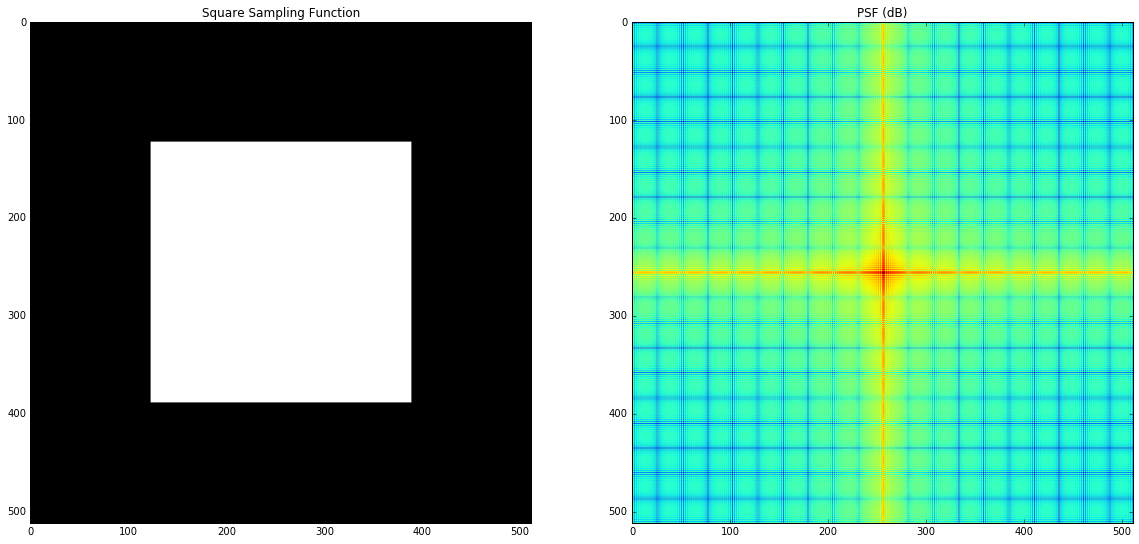

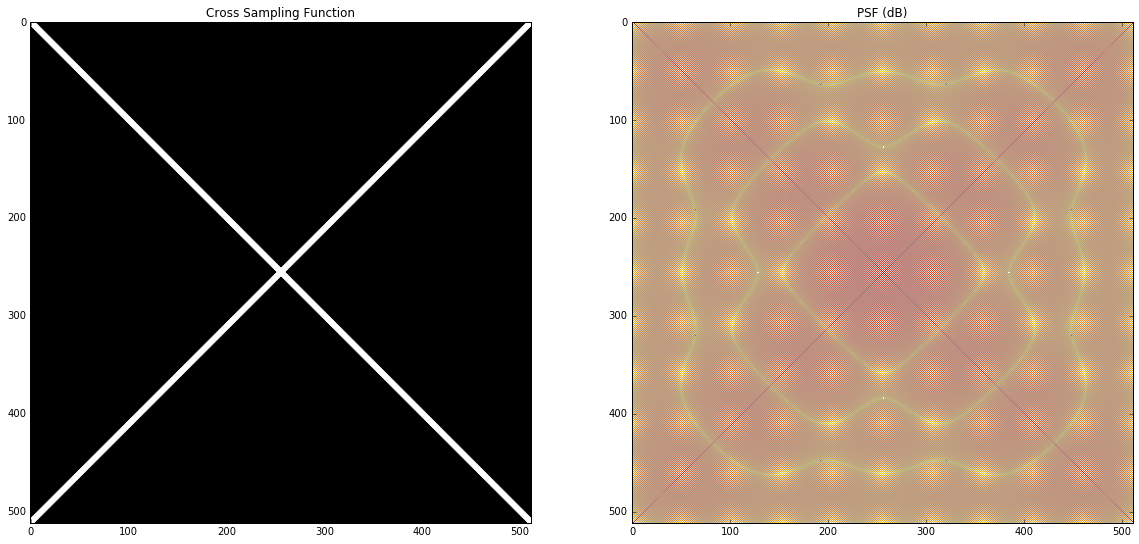

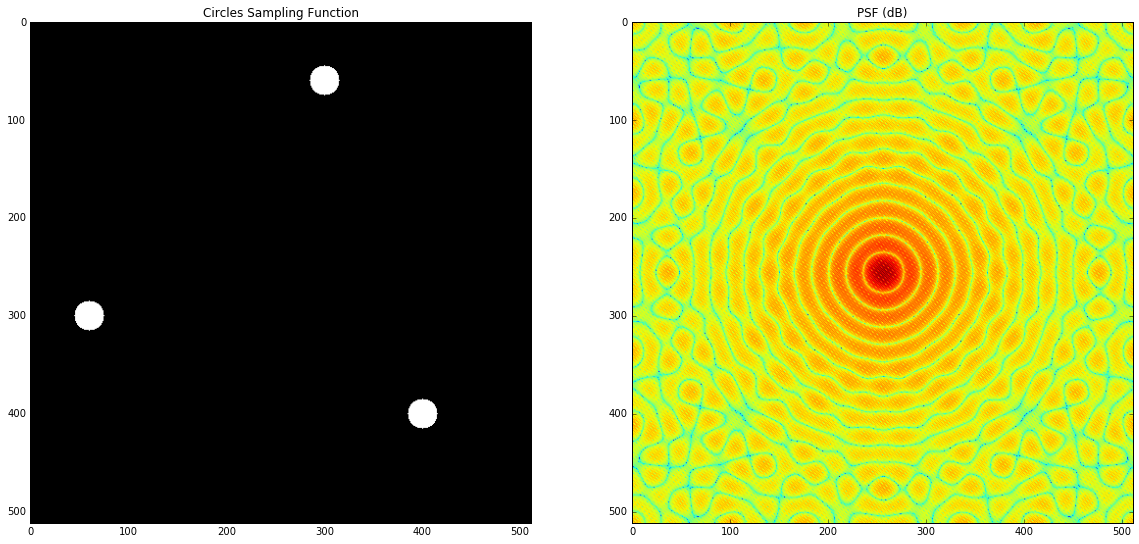

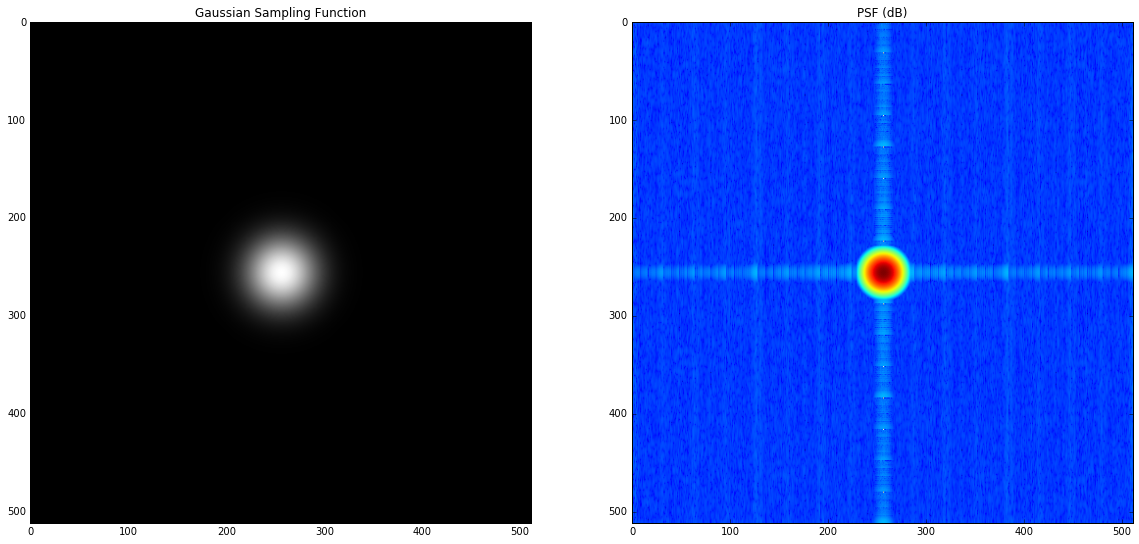

In [18]:
imgSize = 512

#Square
sampling = np.zeros((imgSize,imgSize), dtype='float')
sampling[int(imgSize/4.)-5:int(3.*imgSize/4.)+5, int(imgSize/4.)-5:int(3.*imgSize/4.)+5] = 1.
fig, axes = plt.subplots(figsize=(16,8))
fig.tight_layout()

plt.subplot(1,2,1)
samplingPlot = plt.imshow(sampling)
plt.title('Square Sampling Function')
samplingPlot.set_cmap('gray')

plt.subplot(1,2,2)
psfPlot = plt.imshow(10. * np.log10(np.abs( np.fft.fftshift( np.fft.fft2(sampling)))))
plt.title('PSF (dB)')

#Cross
sampling = np.zeros((imgSize,imgSize), dtype='float')
xpos, ypos = np.mgrid[0:imgSize, 0:imgSize]
idx = np.argwhere(np.abs(xpos-ypos) < 5)
sampling[idx[:,0], idx[:,1]] = 1.
sampling[idx[:,0], (imgSize-1) - idx[:,1]] = 1.
fig, axes = plt.subplots(figsize=(16,8))
fig.tight_layout()

plt.subplot(1,2,1)
samplingPlot = plt.imshow(sampling)
plt.title('Cross Sampling Function')
samplingPlot.set_cmap('gray')

plt.subplot(1,2,2)
psfPlot = plt.imshow(10. * np.log10(np.abs( np.fft.fftshift( np.fft.fft2(sampling)))))
plt.title('PSF (dB)')

#Small Circles
sampling = np.zeros((imgSize,imgSize), dtype='float')
radius = 15
smallCirc = circularSamplingMap(2*radius+1, radius, 0)
sampling[60-radius:60+radius+1, 300-radius:300+radius+1] = smallCirc
sampling[300-radius:300+radius+1, 60-radius:60+radius+1] = smallCirc
sampling[400-radius:400+radius+1, 400-radius:400+radius+1] = smallCirc
fig, axes = plt.subplots(figsize=(16,8))
fig.tight_layout()

plt.subplot(1,2,1)
samplingPlot = plt.imshow(sampling)
plt.title('Circles Sampling Function')
samplingPlot.set_cmap('gray')

plt.subplot(1,2,2)
psfPlot = plt.imshow(10. * np.log10(np.abs( np.fft.fftshift( np.fft.fft2(sampling)))))
plt.title('PSF (dB)')

#Gaussian
xpos, ypos = np.mgrid[0:imgSize,0:imgSize]
sigma = 25.
sampling = np.exp(-1. * (((xpos - (imgSize/2.))**2. + (ypos - (imgSize/2.))**2.) / (2. * sigma**2.)))
fig, axes = plt.subplots(figsize=(16,8))
fig.tight_layout()

plt.subplot(1,2,1)
samplingPlot = plt.imshow(sampling)
plt.title('Gaussian Sampling Function')
samplingPlot.set_cmap('gray')

plt.subplot(1,2,2)
psfPlot = plt.imshow(10. * np.log10(np.abs( np.fft.fftshift( np.fft.fft2(sampling)))))
plt.title('PSF (dB)')

*Row 1: Square sampling function (left) and the resulting PSF (right).
Row 2: Cross sampling function (left) and the resulting PSF (right).
Row 3: Set of circles sampling function (left) and the resulting PSF (right)
Row 4: Gaussian sampling function (left) and the resulting PSF (right)*

Different shapes have a dramatic effect on the resulting PSF and hence the observed image. A square sampling function results in a strong primary lobe but underlying, repeated sidelobe structures. The cross sampling limits the samples to two orientations but at different spatial frequency scales, which results a strong cross pattern and high sidelobes. A collection of small circles at different positions results in a similar Airy disc of a single circle seen earlier. A Gaussian sampling function, which we will return to later in the chapter, has the nice feature that it's Fourier transform is another Gaussian. It is often desirable to taper, or modify, the sampling function to be more Gaussian-like. But, that is to come later.

Returning to the Hubble image which we started the section with we can create a sampling function which approximates the obscuration pattern of the mirror.

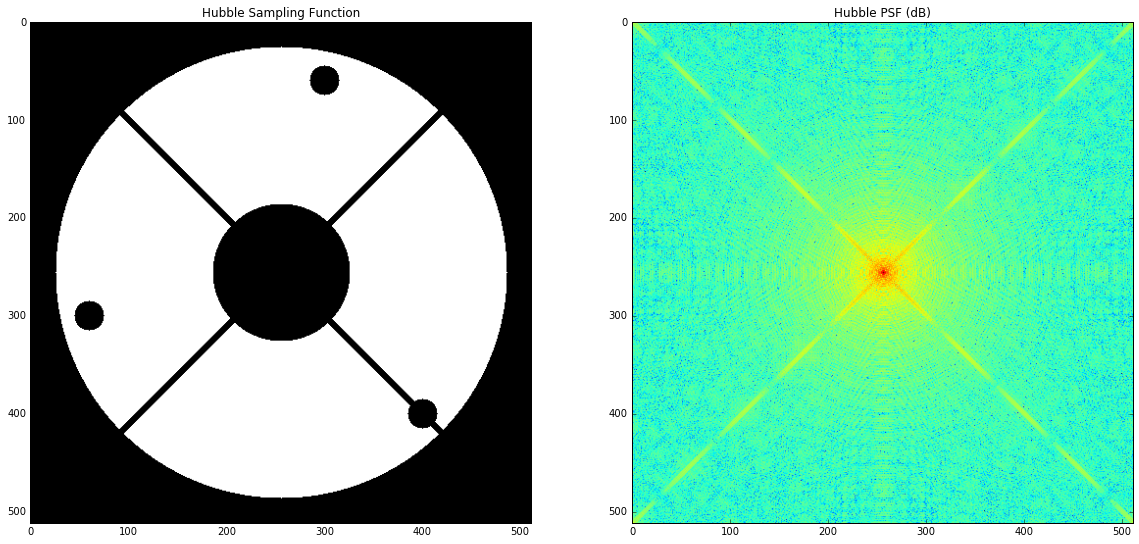

In [19]:
#Approximate Hubble PSF
#http://www.stsci.edu/institute/org/telescopes/Reports/krist_tinytim_spie.pdf

#ring sampling
sampling = circularSamplingMap(512, 230, 70)

#mask circle sections
radius = 15
smallCirc = circularSamplingMap(2*radius+1, radius, 0)
sampling[60-radius:60+radius+1, 300-radius:300+radius+1] -= smallCirc
sampling[300-radius:300+radius+1, 60-radius:60+radius+1] -= smallCirc
sampling[400-radius:400+radius+1, 400-radius:400+radius+1] -= smallCirc

#mask diagonals
xpos, ypos = np.mgrid[0:512, 0:512]
idx = np.argwhere(np.abs(xpos-ypos) < 5)
sampling[idx[:,0], idx[:,1]] = 0.
sampling[idx[:,0], 511 - idx[:,1]] = 0.

fig, axes = plt.subplots(figsize=(16,8))
fig.tight_layout()

plt.subplot(1,2,1)
samplingPlot = plt.imshow(sampling)
plt.title('Hubble Sampling Function')
samplingPlot.set_cmap('gray')

plt.subplot(1,2,2)
psfPlot = plt.imshow(10. * np.log10(np.abs( np.fft.fftshift( np.fft.fft2(sampling)))))
plt.title('Hubble PSF (dB)')

*Left: the approximate sampling pattern of the Hubble Telescope. Right: The resulting PSF from this sampling pattern which is apparent in many Hubble images.*

Based on this approximate sampling pattern for the Hubble telescope we can now see where the PSF shape we see in the image we started the section with has come from. The cross structure comes from the cross in the sampling function, the compact primary lobe is due to the large ring sampling, and the extended, low-level Airy disc is from the small circle patterns.

From these various examples it should be clear that the choice of sampling greatly affects the resulting image. Ideally the sampling function completely covers the visibility domain, but that is never possible. First, the domain is infinite in extent, that is, by building a large telescope the resolution of the resulting image increases, this can go on *ad infinitum*. There is some practical engineering limit or scientific case to set the maximum resolution of an instrument. The second issue, which we have been hiding away in our examples is that we have assumed the sampling function is on a grid already. The array of pixels which make up the images are regularly spaced and all of the same size (i.e. the sample point covers the area of a pixel). In reality of course, telescope sampling functions are not made up of a grid of pixels, they are continuous. The sampling function must be transformed to a be placed on a regular array by some approximate interpolation method called *gridding* (along with an inverse method *degridding*). This will be covered in more detail in the next section. As we will see in interferometry, an assembly of baseline tracks will lead to complex sampling functions dependent on a number of factors such as array layout, oberserving frequency, sky direction, and integration time.

### 5.2.4 KAT-7 Visibility Sampling and Image PSFs

For the remainder of this chapter and the next we will use simulated observations of the KAT-7 array for exploring various aspects of imaging and deconvolution. The KAT-7 array is a seven element array which exists as a pre-cursor to the (currently in construction) MeerKAT array, located at the SKA-SA site in the Northern Cape of South Africa.

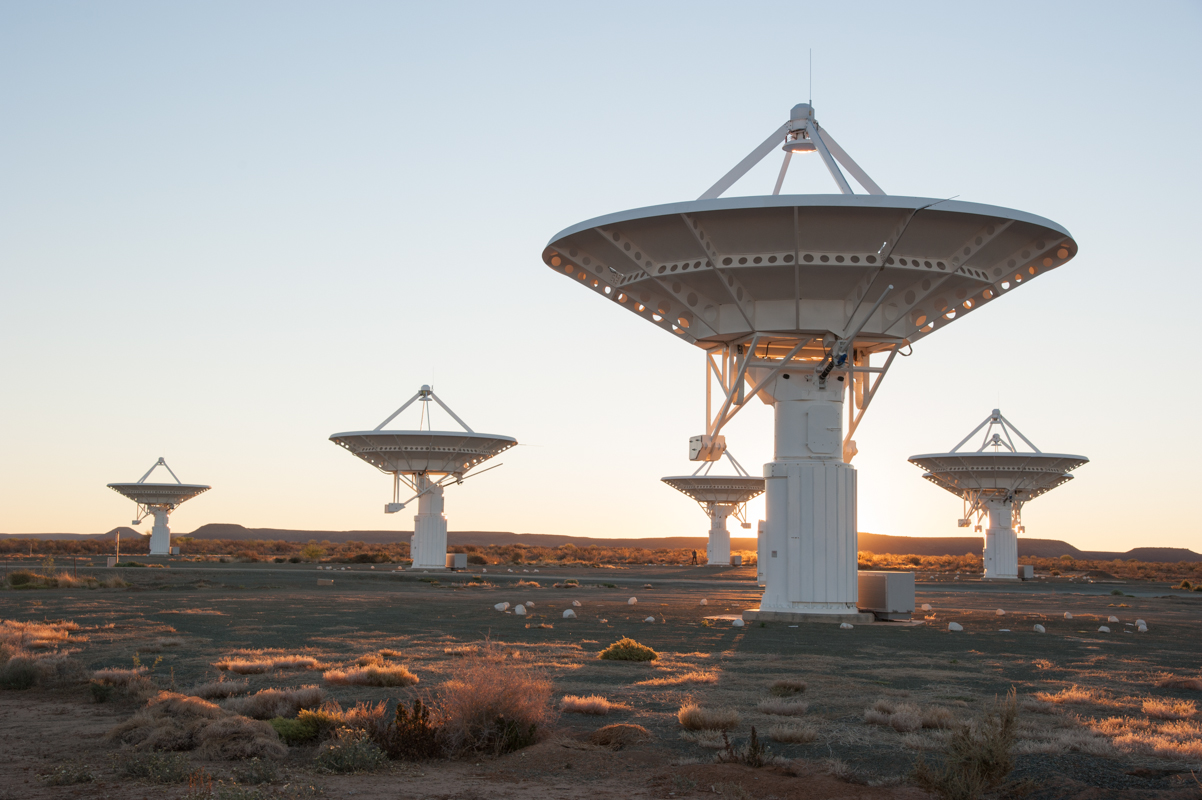

In [20]:
Image(filename='figures/2013_kat7_20.jpg')

*Figure: Inner 5 dishes of the KAT-7 telescope array (pointed at zenith) located in the Northern Cape of South Africa. Credit: SKA-SA (http://www.ska.ac.za/media/2013_kat7.php)*

The seven elements of KAT-7 can be paired into 21 possible interferometric baselines. A typical observation with the array might performed over 6 hours, covering 100 MHz of bandwidth, pointing at a southern declination. This would result in a visibility space sampling, i.e. 'uv coverage', similar to the figure below.

In [21]:
#plotUVcoverage.py -l 1000 -f KAT-7_6h60s_dec-30_10MHz_10chans.ms -s KAT-7_6h60s_dec-30_10MHz_10chans.png
Image(filename='figures/uvcoverage/KAT-7_6h60s_dec-30_10MHz_10chans.png')

IOError: [Errno 2] No such file or directory: u'figures/uvcoverage/KAT-7_6h60s_dec-30_10MHz_10chans.png'

*Figure: uv coverage from KAT-7 during a 6 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -30 degrees.*

The various arcs in the sampling figure are colloquially called *visibility tracks* and are from a single baseline. Each track has a width, which has been coloured, to represent the bandwidth of the observation. The lowest frequency of the observation is represented by the red side of the track, and the highest frequency is the blue side. As can be seen, some tracks overlap in regions of the visibility space. These regions are being sampled multiple times during and observation, the issue of how to deal with this multi-sampling will come up latter in the chapter when we discuss weighting schemes. There are also empty regions of the sampling space, and one might talk about the 'holes in the uv coverage'. Notably is the central hole in the coverage, if the auto-correlations were included in an observation, this is the location in visibility space where these samples would be placed. As we created a PSF response from the Hubble sampling function, we can also create a PSF response for this KAT-7 uv coverage. 

In [22]:
#wsclean -name KAT-7_6h60s_dec-30_10MHz_10chans -size 512 512 -scale 0.004 -nosmallinversion -weight natural
# -makepsf KAT-7_6h60s_dec-30_10MHz_10chans.ms
gc = aplpy.FITSFigure('figures/psfs/KAT-7_6h60s_dec-30_10MHz_10chans_natural-psf.fits')
gc.show_colorscale(cmap='viridis')
gc.add_colorbar()

NameError: name 'aplpy' is not defined

*Figure: Point Spread Function from KAT-7 during a 6 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -30 degrees. The peak central pixel has a value of 1, but the color scale has been adjusted to show the sidelobe structure.*

The central peaked lobe of the PSF has a characteristic size which relates to the extend of the uv plane sampling distribution. By definition of how the PSF is produced, the central peak is the maximum of the image has a value of 1. There are secondary, local maximums and minimums which are known as PSF sidelobes. Some of the brighest sidelobes are over 20% of the primary PSF lobe which can lead to significant issues when differentiating between real sky sources and the artefacts due to the system. There are various ways to reduce these sidelobes: observe for longer time periods, increase the observation bandwidth, choose a different weighting scheme, or use more baselines among other case specific methods.

By controlling the observation length, starting with a short 'snapshot' observation to progressively longer observations we can see how the uv coverage increases. 

In [ ]:
#plotUVcoverage.py -l 1000 -f KAT-7_0.167h60s_dec-30_10MHz_10chans.ms -s KAT-7_0.167h60s_dec-30_10MHz_10chans.png
Image(filename='figures/uvcoverage/KAT-7_0.167h60s_dec-30_10MHz_10chans.png')

*Figure: snapshot uv coverage from KAT-7 during a 10 minute, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -30 degrees.*

With a short 'snapshot' observation the visibility plan is only sparsely sampled, and due to the random distribution of KAT-7 there is no overlap in baseline sampling for such a short observation. All 21 unique baselines can be counted. You may notice there are 42 short tracks in this image, but that is from the conjugated baselines since a baseline pair, say antenna A and antenna B, can be seen as an (A,B) baseline or a (B,A) baseline. The sparsity of the visibility space sampling results in a poor PSF response as there are many sidelobes which are nearly as bright as the primary PSF lobe.

In [ ]:
#wsclean -name KAT-7_0.167h60s_dec-30_10MHz_10chans -size 512 512 -scale 0.004 -nosmallinversion -weight natural
# -makepsf KAT-7_0.167h60s_dec-30_10MHz_10chans.ms
gc = aplpy.FITSFigure('figures/psfs/KAT-7_0.167h60s_dec-30_10MHz_10chans_natural-psf.fits')
gc.show_colorscale(cmap='viridis')
gc.add_colorbar()

*Figure: Point Spread Function from KAT-7 during a snapshot 10 minute, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -30 degrees. Many of the sidelobes have nearly equivalent flux as compared to the central primary lobe.*

Increasing the observation lenght to 2 hours begins to fill in the visibility space, with some of the baseline tracks beginning to overlap and the resulting PSF sidelobes begin to be reduced relative to the primary lobe.

In [ ]:
#plotUVcoverage.py -l 1000 -f KAT-7_2h60s_dec-30_10MHz_10chans.ms -s KAT-7_2h60s_dec-30_10MHz_10chans.png
Image(filename='figures/uvcoverage/KAT-7_2h60s_dec-30_10MHz_10chans.png')

*Figure: uv coverage from KAT-7 during a 2 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -30 degrees.*

In [ ]:
#wsclean -name KAT-7_2h60s_dec-30_10MHz_10chans -size 512 512 -scale 0.004 -nosmallinversion -weight natural
# -makepsf KAT-7_2h60s_dec-30_10MHz_10chans.ms
gc = aplpy.FITSFigure('figures/psfs/KAT-7_2h60s_dec-30_10MHz_10chans_natural-psf.fits')
gc.show_colorscale(cmap='viridis')
gc.add_colorbar()

*Figure: Point Spread Function from KAT-7 during a 2 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -30 degrees.*

We can see in the 2 hour PSF that many of the sidelobes, particularly those near the edge, have been 'washed' out and the sidelobes near the centre are slightly reduced in flux compared to the snapshot PSF. We can see that with increasing the observation to 6 hours that most of the sidelobes are washed out. Increasing the observation length further to 12 hours we can see the effect of near-completely filling in the visibility space is a strong central peak with small sidelobes.

In [ ]:
#plotUVcoverage.py -l 1000 -f KAT-7_12h60s_dec-30_10MHz_10chans.ms -s KAT-7_12h60s_dec-30_10MHz_10chans.png
Image(filename='figures/uvcoverage/KAT-7_12h60s_dec-30_10MHz_10chans.png')

*Figure: uv coverage from KAT-7 during a 12 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -30 degrees.*

In [ ]:
#wsclean -name KAT-7_12h60s_dec-30_10MHz_10chans -size 512 512 -scale 0.004 -nosmallinversion -weight natural
# -makepsf KAT-7_12h60s_dec-30_10MHz_10chans.ms
gc = aplpy.FITSFigure('figures/psfs/KAT-7_12h60s_dec-30_10MHz_10chans_natural-psf.fits')
gc.show_colorscale(cmap='viridis')
gc.add_colorbar()

*Figure: Point Spread Function from KAT-7 during a 12 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -30 degrees.*

As we can see in the uv coverage plots, there is a width to the tracks due to the amount of frequency bandwidth sampled during an observation. If we decrease the bandwidth to 10 MHz for the 6 hour observation we end up with a sparser sampling of the visibility space compared to the 100 MHz bandwidth observation.

In [ ]:
#plotUVcoverage.py -l 1000 -f KAT-7_6h60s_dec-30_10MHz_1chans.ms -s KAT-7_6h60s_dec-30_10MHz_10chans.png
Image(filename='figures/uvcoverage/KAT-7_6h60s_dec-30_10MHz_1chans.png')

*Figure: uv coverage from KAT-7 during a 6 hour, 10 MHz observation (1440 MHz - 1450 MHz) of a field at declination -30 degrees.*

In [ ]:
#wsclean -name KAT-7_6h60s_dec-30_10MHz_1chans -size 512 512 -scale 0.004 -nosmallinversion -weight natural
# -makepsf KAT-7_6h60s_dec-30_10MHz_1chans.ms
# Note: there is a odd issue here with single channel measurement set images, wsclean, and aplpy
# using astropy FITS interface to workaround the issue
import astropy.io.fits
fh = astropy.io.fits.open('figures/psfs/KAT-7_6h60s_dec-30_10MHz_1chans_natural-psf.fits')
img = fh[0].data
gc = aplpy.FITSFigure(img[0,0])
gc.show_colorscale(cmap='viridis')
gc.add_colorbar()

*Figure: Point Spread Function from KAT-7 during a 6 hour, 10 MHz observation (1440 MHz - 1450 MHz) of a field at declination -30 degrees.*

The resulting PSF of the reduced bandwidth case has a similar sidelobe layout, but are larger compared to the original 100 MHz bandwidth case.

Conversely, if we increase the bandwidth during an observation by a factor of 10 to 1 GHz the visibility space will be well sampled.

In [ ]:
#plotUVcoverage.py -l 1000 -f KAT-7_6h60s_dec-30_10MHz_100chans.ms -s KAT-7_6h60s_dec-30_10MHz_10chans.png
Image(filename='figures/uvcoverage/KAT-7_6h60s_dec-30_10MHz_100chans.png')

*Figure: uv coverage from KAT-7 during a 6 hour, 1 GHz observation (1440 MHz - 2440 MHz) of a field at declination -30 degrees.*

The increase in bandwidth results in much of the visibility space being well sampled, and many of the regions oversampled multiple times. But, there do remain holes in the sampling, especially near the centre. There is a physical limit to how close the antennas can be, a KAT-7 dish is 12 metres in diaemter, so no baseline can be shorter than 12 metres.

In [ ]:
#wsclean -name KAT-7_6h60s_dec-30_10MHz_100chans -size 512 512 -scale 0.004 -nosmallinversion -weight natural
# -makepsf KAT-7_6h60s_dec-30_10MHz_100chans.ms
gc = aplpy.FITSFigure('figures/psfs/KAT-7_6h60s_dec-30_10MHz_100chans_natural-psf.fits')
gc.show_colorscale(cmap='viridis')
gc.add_colorbar()

*Figure: Point Spread Function from KAT-7 during a 6 hour, 1 GHz observation (1440 MHz - 2440 MHz) of a field at declination -30 degrees.*

Some structure in the PSF sidelobes still exist due to the remaining holes in the coverage, but are lower compared to all other examples we have looked at so far. Increasing the amount of bandwidth sampled during an observation will result in a better sampled visibility space, and hence a better initial image. This is an important idea which over the years has led to a push towards increasing the sampling bandwidth of new telescope arrays. There is a limit to taking advantage of increased bandwidth depending on the science case, but that is an advanced topic not covered in this work.

Before this section concludes there is one more parameter which effects a radio interferometric array PSF which should be discussed. Unlike most other telescopes interferometric arrays have a declination dependent PSF. The short reason for the declination dependence is that the array is distributed in 3-D space, usually on the surface of the Earth, and the baselines are projected onto a 2-D surface. Depending on the pointing direction the 2-D projection will result in different baseline tracks. This is one of the great advantages of interferometric arrays, as the Earth rotates the baseline tracks are drawn out to fill in regions of the visibility space. But, it adds a complication to observations as the PSF changes with every observation.

Observing at the north and sourth celestial poles results in circular baseline tracks which results in a compact PSF primary lobe and low sidelobes. Additionally, one of the poles (depending on if the array is in the northern or southern hemisphere) is observable for the full extent of the sidereal day.

In [ ]:
#plotUVcoverage.py -l 1000 -f KAT-7_6h60s_dec-90_10MHz_10chans.ms -s KAT-7_6h60s_dec-90_10MHz_10chans.png
Image(filename='figures/uvcoverage/KAT-7_6h60s_dec-90_10MHz_10chans.png')

*Figure: uv coverage from KAT-7 during a 6 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -90 degrees (South Celestial Pole).*

In [ ]:
#wsclean -name KAT-7_6h60s_dec-90_10MHz_10chans -size 512 512 -scale 0.004 -nosmallinversion -weight natural
# -makepsf KAT-7_6h60s_dec-90_10MHz_10chans.ms
gc = aplpy.FITSFigure('figures/psfs/KAT-7_6h60s_dec-90_10MHz_10chans_natural-psf.fits')
gc.show_colorscale(cmap='viridis')
gc.add_colorbar()

*Figure: Point Spread Function from KAT-7 during a 6 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -90 degrees (South Celestial Pole).*

The resulting PSF for the south celestial pole looks similar to the Bessel function from an Airy disc sampling function. As the observation length and bandwidth is increased the PSF will approach as Bessel function response.

Observing at an intermediate declination, such as -60 degrees, results in tracks which are slightly elliptical and over-sampling occurs in some regions of the visibility space.

In [ ]:
#plotUVcoverage.py -l 1000 -f KAT-7_6h60s_dec-60_10MHz_10chans.ms -s KAT-7_6h60s_dec-60_10MHz_10chans.png
Image(filename='figures/uvcoverage/KAT-7_6h60s_dec-60_10MHz_10chans.png')

*Figure: uv coverage from KAT-7 during a 6 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -60 degrees.*

The PSF from this sampling has arced sidelobes which are brighter than the sidelobe rings at -90 declination, but not as strong as the prominent sidelobes at -30 degrees.

In [ ]:
#wsclean -name KAT-7_6h60s_dec-60_10MHz_10chans -size 512 512 -scale 0.004 -nosmallinversion -weight natural
# -makepsf KAT-7_6h60s_dec-60_10MHz_10chans.ms
gc = aplpy.FITSFigure('figures/psfs/KAT-7_6h60s_dec-60_10MHz_10chans_natural-psf.fits')
gc.show_colorscale(cmap='viridis')
gc.add_colorbar()

*Figure: Point Spread Function from KAT-7 during a 6 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination -60 degrees.*

 We can see that the baseline sampling changes smoothly as a function of declination, with the tracks being circular at the north and sotuh poles with the tracks becoming elliptical as the observation moves away from the poles. This leads the particularly odd case of observations at 0 degrees declination. The tracks follow elliptical paths, at declination 0 degrees the minor semiaxis is of size 0, this results in tracks which are straight lines.

In [ ]:
#plotUVcoverage.py -l 1000 -f KAT-7_6h60s_dec0_10MHz_10chans.ms -s KAT-7_6h60s_dec0_10MHz_10chans.png
Image(filename='figures/uvcoverage/KAT-7_6h60s_dec0_10MHz_10chans.png')

*Figure: uv coverage from KAT-7 during a 6 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination 0 degrees.*

This effect results in a well formed PSF in the east-west direction, but a poor, high-sidelobe response in the north-south direction. Observations around declination 0 degrees are often avoided for this reason.

In [ ]:
#wsclean -name KAT-7_6h60s_dec0_10MHz_10chans -size 512 512 -scale 0.004 -nosmallinversion -weight natural
# -makepsf KAT-7_6h60s_dec0_10MHz_10chans.ms
gc = aplpy.FITSFigure('figures/psfs/KAT-7_6h60s_dec0_10MHz_10chans_natural-psf.fits')
gc.show_colorscale(cmap='viridis')
gc.add_colorbar()

*Figure: Point Spread Function from KAT-7 during a 6 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination 0 degrees.*

In a final example showing how the PSF response changes with declination we can look at an observation of a northern hemisphere field from a southern hemisphere array.

In [ ]:
#plotUVcoverage.py -l 1000 -f KAT-7_6h60s_dec30_10MHz_10chans.ms -s KAT-7_6h60s_dec30_10MHz_10chans.png
Image(filename='figures/uvcoverage/KAT-7_6h60s_dec30_10MHz_10chans.png')

*Figure: uv coverage from KAT-7 during a 6 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination +30 degrees.*

Comparing this coverage to that of the coverage for a field at declination -30 degrees one should notice that there is a similarity between the two. In fact, both sample different sections of the same complete uv ellipses, as they are effectively conjugates of each other, but the total possible coverage for the northern hemisphere field is limited compared to the sothern hemisphere due horizon limits.

Hopefully at this point we are starting to build up intuition on what the resulting PSF response will be based on the uv coverage. For example, in our declination +30 degrees case the coverage is sampled further out in the top-right and bottom-left quadrants compared to the top-left and bottom-right quandrants. This should indicate that the resulting PSF primary lobe will be elliptical, as we are better sampling the diagonal modes in one direction versus the other. IN the PSF response below we can see that the primary lobe is indeed elliptical.

In [ ]:
#wsclean -name KAT-7_6h60s_dec30_10MHz_10chans -size 512 512 -scale 0.004 -nosmallinversion -weight natural
# -makepsf KAT-7_6h60s_dec30_10MHz_10chans.ms
gc = aplpy.FITSFigure('figures/psfs/KAT-7_6h60s_dec30_10MHz_10chans_natural-psf.fits')
gc.show_colorscale(cmap='viridis')
gc.add_colorbar()

*Figure: Point Spread Function from KAT-7 during a 6 hour, 100 MHz observation (1440 MHz - 1540 MHz) of a field at declination +30 degrees.*

The effect of an observation-dependent PSF will play an important role again and again as we progress through the imaging and particularly when we come to deconvolution in the next chapter.

It is worth bringing up the idea of the 'ideal' sampling function and resulting PSF for a moment. Obviously the ideal sampling function would sample all spatial frequencies out to infinite resolution. But, of course this is not realistic, instrumentational limits do not make this possible, and the resulting amount of data would be infinite. This is a bit of a strawman arguement, a more realistic ideal PSF would be to fully sample all spatial frequencies out to Nyquist frequency based on the desired resolution. Effectively this would be an Airy disc sampling function. But, the sharp edge of the Airy function results in strong PSF sidelobes. If instead, a Gaussian is used, this has a nice feature in which the Fourier transform of a Gaussian is another Gaussian. The scale of this Gaussian is with a full width at half maximum (FWHM) on the scale of the Airy disc. This idea will arise again when the restored image is introduced in the deconvolution chapter.

Up until now we have been creating sampling functions by selecting pixels in an image, that is, we have been picking sampling fuctions which are on a regular grid. But, in interferometry the baselines are (almost) never on a grid, the individual baseline tracks are sampled at a given time and not a given position, this leads to a irregular sampling of the visibility domain. An image can be constructed out of these non-uniformly placed samples with a standard Fourier Transform, but that is a computationally slow method. If the samples are on a grid, a fast Fourier Transform method can be used, which greatly decreases the computational load. In order to take advantage of this improvement a 'gridding' step is performed on the visibility samples. This is covered in the next section along with its complimentary process of degridding which is used required for many modern deconvolution methods.

***

Next: [5.3 Gridding and Degridding for using the FFT](5_3_gridding_and_degridding.ipynb)